##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Generating Images with Little Data Using S3GAN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/s3gan_generation_with_tf_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/s3gan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/s3gan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/s3gan_generation_with_tf_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=s3gan"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

This notebook is a demo of Generative Adversarial Networks trained on ImageNet with as little as 2.5% labeled data using self- and semi-supervised learning techniques. Both generator and discriminator models are available on [TF Hub](https://tfhub.dev/s?publisher=google&q=compare_gan).

For more information about the models and the training procedure see our [blogpost](https://ai.googleblog.com/2019/03/reducing-need-for-labeled-data-in.html) and the [paper](https://arxiv.org/abs/1903.02271) [1].
The code for training these models is available on [GitHub](https://github.com/google/compare_gan).

To get started, connect to a runtime and follow these steps:

1. (Optional) Select a model in the second code cell below.
2. Click **Runtime > Run all** to run each cell in order.
  * Afterwards, the interactive visualizations should update automatically when you modify the settings using the sliders and dropdown menus.

Note: if you run into any issues, youn can try restarting the runtime and rerunning all cells from scratch by clicking **Runtime > Restart and run all...**.

[1] Mario Lucic\*, Michael Tschannen\*, Marvin Ritter\*, Xiaohua Zhai, Olivier
    Bachem, Sylvain Gelly, [High-Fidelity Image Generation With Fewer Labels](https://arxiv.org/abs/1903.02271), ICML 2019.

## Setup

In [2]:
# @title Imports and utility functions
import os

import IPython
from IPython.display import display
import numpy as np
import PIL.Image
import pandas as pd
import six

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

def imgrid(imarray, cols=8, pad=1):
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant')
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  return grid[:-pad, :-pad]


def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  if six.PY3:
    str_file = six.BytesIO()
  else:
    str_file = six.StringIO()
  PIL.Image.fromarray(a).save(str_file, format)
  png_data = str_file.getvalue()
  try:
    disp = display(IPython.display.Image(png_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp


class Generator(object):

  def __init__(self, module_spec):
    self._module_spec = module_spec
    self._sess = None
    self._graph = tf.Graph()
    self._load_model()

  @property
  def z_dim(self):
    return self._z.shape[-1].value

  @property
  def conditional(self):
    return self._labels is not None

  def _load_model(self):
    with self._graph.as_default():
      self._generator = hub.Module(self._module_spec, name="gen_module",
                                   tags={"gen", "bsNone"})
      input_info = self._generator.get_input_info_dict()
      inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
                for k, v in self._generator.get_input_info_dict().items()}
      self._samples = self._generator(inputs=inputs, as_dict=True)["generated"]
      print("Inputs:", inputs)
      print("Outputs:", self._samples)
      self._z = inputs["z"]
      self._labels = inputs.get("labels", None)

  def _init_session(self):
    if self._sess is None:
      self._sess = tf.Session(graph=self._graph)
      self._sess.run(tf.global_variables_initializer())

  def get_noise(self, num_samples, seed=None):
    if np.isscalar(seed):
      np.random.seed(seed)
      return np.random.normal(size=[num_samples, self.z_dim])
    z = np.empty(shape=(len(seed), self.z_dim), dtype=np.float32)
    for i, s in enumerate(seed):
      np.random.seed(s)
      z[i] = np.random.normal(size=[self.z_dim])
    return z

  def get_samples(self, z, labels=None):
    with self._graph.as_default():
      self._init_session()
      feed_dict = {self._z: z}
      if self.conditional:
        assert labels is not None
        assert labels.shape[0] == z.shape[0]
        feed_dict[self._labels] = labels
      samples = self._sess.run(self._samples, feed_dict=feed_dict)
      return np.uint8(np.clip(256 * samples, 0, 255))


class Discriminator(object):

  def __init__(self, module_spec):
    self._module_spec = module_spec
    self._sess = None
    self._graph = tf.Graph()
    self._load_model()

  @property
  def conditional(self):
    return "labels" in self._inputs

  @property
  def image_shape(self):
    return self._inputs["images"].shape.as_list()[1:]

  def _load_model(self):
    with self._graph.as_default():
      self._discriminator = hub.Module(self._module_spec, name="disc_module",
                                       tags={"disc", "bsNone"})
      input_info = self._discriminator.get_input_info_dict()
      self._inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
                      for k, v in input_info.items()}
      self._outputs = self._discriminator(inputs=self._inputs, as_dict=True)
      print("Inputs:", self._inputs)
      print("Outputs:", self._outputs)

  def _init_session(self):
    if self._sess is None:
      self._sess = tf.Session(graph=self._graph)
      self._sess.run(tf.global_variables_initializer())

  def predict(self, images, labels=None):
    with self._graph.as_default():
      self._init_session()
      feed_dict = {self._inputs["images"]: images}
      if "labels" in self._inputs:
        assert labels is not None
        assert labels.shape[0] == images.shape[0]
        feed_dict[self._inputs["labels"]] = labels
      return self._sess.run(self._outputs, feed_dict=feed_dict)

2023-11-07 12:22:55.109710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 12:22:55.109762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 12:22:55.111269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Instructions for updating:
non-resource variables are not supported in the long term


## Select a model

In [3]:
# @title Select a model { run: "auto" }

model_name = "S3GAN 128x128 20% labels (FID 6.9, IS 98.1)"  # @param ["S3GAN 256x256 10% labels (FID 8.8, IS 130.7)", "S3GAN 128x128 2.5% labels (FID 12.6, IS 48.7)", "S3GAN 128x128 5% labels (FID 8.4, IS 74.0)", "S3GAN 128x128 10% labels (FID 7.6, IS 90.3)", "S3GAN 128x128 20% labels (FID 6.9, IS 98.1)"]
models = {
    "S3GAN 256x256 10% labels": "https://tfhub.dev/google/compare_gan/s3gan_10_256x256/1",
    "S3GAN 128x128 2.5% labels": "https://tfhub.dev/google/compare_gan/s3gan_2_5_128x128/1",
    "S3GAN 128x128 5% labels": "https://tfhub.dev/google/compare_gan/s3gan_5_128x128/1",
    "S3GAN 128x128 10% labels": "https://tfhub.dev/google/compare_gan/s3gan_10_128x128/1",
    "S3GAN 128x128 20% labels": "https://tfhub.dev/google/compare_gan/s3gan_20_128x128/1",
}

module_spec = models[model_name.split(" (")[0]]
print("Module spec:", module_spec)

tf.reset_default_graph()
print("Loading model...")
sampler = Generator(module_spec)
print("Model loaded.")

Module spec: https://tfhub.dev/google/compare_gan/s3gan_20_128x128/1
Loading model...


2023-11-07 12:23:17.360038: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Inputs: {'labels': <tf.Tensor 'labels:0' shape=(?,) dtype=int32>, 'z': <tf.Tensor 'z:0' shape=(?, 120) dtype=float32>}
Outputs: Tensor("gen_module_apply_default/generator_1/truediv:0", shape=(?, 128, 128, 3), dtype=float32)
Model loaded.


## Sample

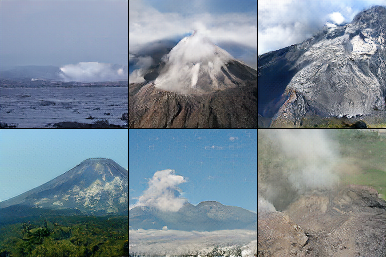

In [4]:
# @title Sampling { run: "auto" }

num_rows = 2  # @param {type: "slider", min:1, max:16}
num_cols = 3  # @param {type: "slider", min:1, max:16}
noise_seed = 23  # @param {type:"slider", min:0, max:100, step:1}
label_str = "980) volcano"  # @param ["-1) Random", "0) tench, Tinca tinca", "1) goldfish, Carassius auratus", "2) great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias", "3) tiger shark, Galeocerdo cuvieri", "4) hammerhead, hammerhead shark", "5) electric ray, crampfish, numbfish, torpedo", "6) stingray", "7) cock", "8) hen", "9) ostrich, Struthio camelus", "10) brambling, Fringilla montifringilla", "11) goldfinch, Carduelis carduelis", "12) house finch, linnet, Carpodacus mexicanus", "13) junco, snowbird", "14) indigo bunting, indigo finch, indigo bird, Passerina cyanea", "15) robin, American robin, Turdus migratorius", "16) bulbul", "17) jay", "18) magpie", "19) chickadee", "20) water ouzel, dipper", "21) kite", "22) bald eagle, American eagle, Haliaeetus leucocephalus", "23) vulture", "24) great grey owl, great gray owl, Strix nebulosa", "25) European fire salamander, Salamandra salamandra", "980) volcano"]

num_samples = num_rows * num_cols
z = sampler.get_noise(num_samples, seed=noise_seed)

label = int(label_str.split(')')[0])
if label == -1:
  labels = np.random.randint(0, num_classes, size=(num_samples))
else:
  labels = np.asarray([label] * num_samples)

samples = sampler.get_samples(z, labels)
imshow(imgrid(samples, cols=num_cols))

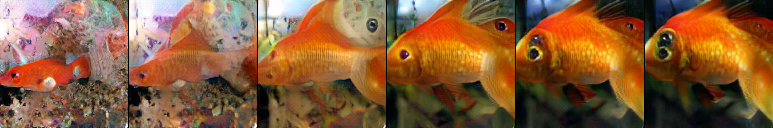

In [5]:
# @title Interpolation { run: "auto" }

num_samples = 1  # @param {type: "slider", min: 1, max: 6, step: 1}
num_interps = 6  # @param {type: "slider", min: 2, max: 10, step: 1}
noise_seed_A = 11  # @param {type: "slider", min: 0, max: 100, step: 1}
noise_seed_B = 0  # @param {type: "slider", min: 0, max: 100, step: 1}
label_str = "1) goldfish, Carassius auratus"  # @param ["0) tench, Tinca tinca", "1) goldfish, Carassius auratus", "2) great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias", "3) tiger shark, Galeocerdo cuvieri", "4) hammerhead, hammerhead shark", "5) electric ray, crampfish, numbfish, torpedo", "6) stingray", "7) cock", "8) hen", "9) ostrich, Struthio camelus", "10) brambling, Fringilla montifringilla", "11) goldfinch, Carduelis carduelis", "12) house finch, linnet, Carpodacus mexicanus", "13) junco, snowbird", "14) indigo bunting, indigo finch, indigo bird, Passerina cyanea", "15) robin, American robin, Turdus migratorius", "16) bulbul", "17) jay", "18) magpie", "19) chickadee", "20) water ouzel, dipper", "21) kite", "22) bald eagle, American eagle, Haliaeetus leucocephalus", "23) vulture", "24) great grey owl, great gray owl, Strix nebulosa", "25) European fire salamander, Salamandra salamandra"]


def interpolate(A, B, num_interps):
  alphas = np.linspace(0, 1, num_interps)
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  return np.array([((1-a)*A + a*B)/np.sqrt(a**2 + (1-a)**2) for a in alphas])


def interpolate_and_shape(A, B, num_interps):
  interps = interpolate(A, B, num_interps)
  return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                 .reshape(num_samples * num_interps, -1))

label = int(label_str.split(')')[0])
labels = np.asarray([label] * num_samples * num_interps)


z_A = sampler.get_noise(num_samples, seed=noise_seed_A)
z_B = sampler.get_noise(num_samples, seed=noise_seed_B)
z = interpolate_and_shape(z_A, z_B, num_interps)

samples = sampler.get_samples(z, labels)
imshow(imgrid(samples, cols=num_interps))

## Discriminator

In [6]:
disc = Discriminator(module_spec)

batch_size = 4
num_classes = 1000
images = np.random.random(size=[batch_size] + disc.image_shape)
labels = np.random.randint(0, num_classes, size=(batch_size))

disc.predict(images, labels=labels)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Inputs: {'images': <tf.Tensor 'images:0' shape=(?, 128, 128, 3) dtype=float32>, 'labels': <tf.Tensor 'labels:0' shape=(?,) dtype=int32>}
Outputs: {'prediction': <tf.Tensor 'disc_module_apply_default/discriminator/Sigmoid:0' shape=(?, 1) dtype=float32>}


{'prediction': array([[0.82321596],
        [0.89030766],
        [0.8621535 ],
        [0.88563365]], dtype=float32)}